<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test basic DSP functionalities

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
from optic.dsp.core import pnorm, signal_power, decimate, resample, lowPassFIR, firFilter, clockSamplingInterp, quantizer, upsample, pulseShape, finddelay
from optic.utils import parameters
from optic.plot import eyediagram, plotPSD, pconst
from optic.comm.modulation import modulateGray
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

from optic.models.devices import adc
from optic.dsp.clockRecovery import gardnerClockRecovery

In [3]:
%load_ext autoreload
%autoreload 2

## Test rational resample

C:\Users\edson.DESKTOP-54IJM4F\anaconda3\envs\opticommpy-env\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 0.1)

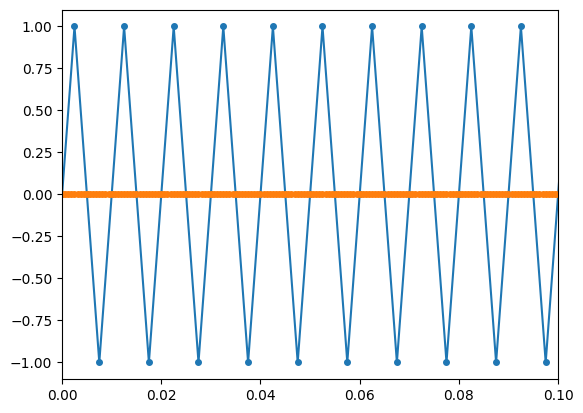

In [4]:
Fs = 400
fc = 100

t = np.arange(0,4096)*(1/Fs)
π = np.pi

sig = np.sin(2*π*fc*t)

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

paramDec = parameters()
paramDec.SpS_in = 4
paramDec.SpS_out = 16
paramDec.Rs = fc

resFactor = paramDec.SpS_out/paramDec.SpS_in

t_dec = np.arange(0, int(resFactor*4096))*(1/(resFactor*Fs))
sig_dec = resample(sig, paramDec)

plt.plot(t_dec, sig_dec,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

## Test sampling clock converter

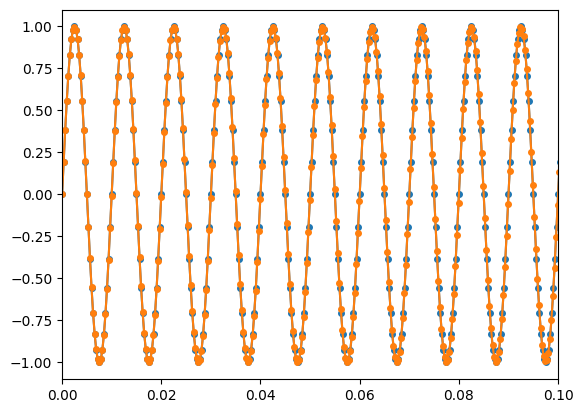

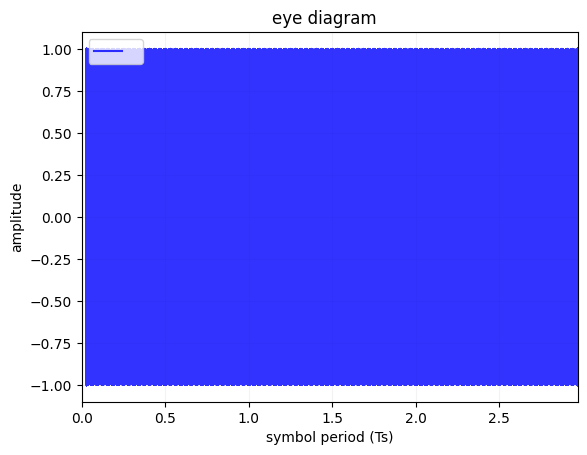

In [5]:
Fs = 3200
fc = 100

t = np.arange(0, 300000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.sin(2*π*fc*t)

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(min(t), max(t))

# intermpolate signal to a given clock sampling frequency and jitter
Fs_in = Fs
Fs_out = 1.001*Fs
AAF = False
jitter_rms = 1e-9

t_dec = clockSamplingInterp(t.reshape(-1,1), Fs_in, Fs_out, jitter_rms)
sig_dec = clockSamplingInterp(sig.reshape(-1,1), Fs_in, Fs_out, jitter_rms)
plt.plot(t_dec, sig_dec,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

eyediagram(sig_dec.reshape(-1,), sig_dec.size, int(Fs//fc), n=3, ptype='fast', plotlabel=None)

## Test signal quantizer

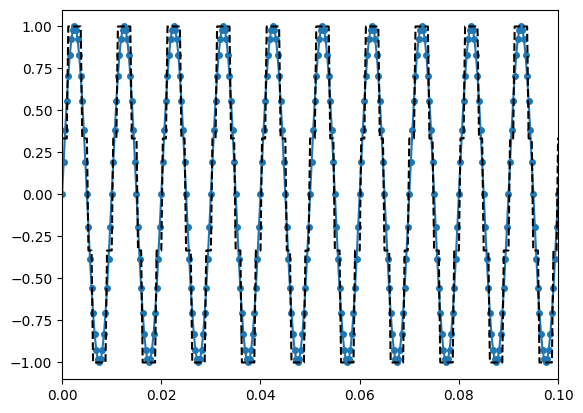

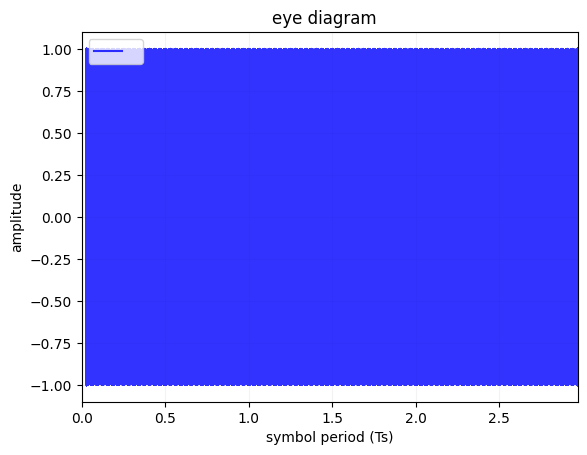

In [6]:
Fs = 3200
fc = 100

t = np.arange(0, 300000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.sin(2*π*fc*t) #+ np.sin(6*π*fc*t)/3 + np.sin(10*π*fc*t)/5

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(min(t), max(t))

# quantizer
nBits = 2
sig_q = quantizer(sig.reshape(-1,1), nBits)

plt.plot(t, sig_q,'--k',markersize=4);
plt.xlim(0, 10*1/fc)

eyediagram(sig_dec.reshape(-1,), sig_dec.size, int(Fs//fc), n=3, ptype='fast', plotlabel=None)

## Test ADC model

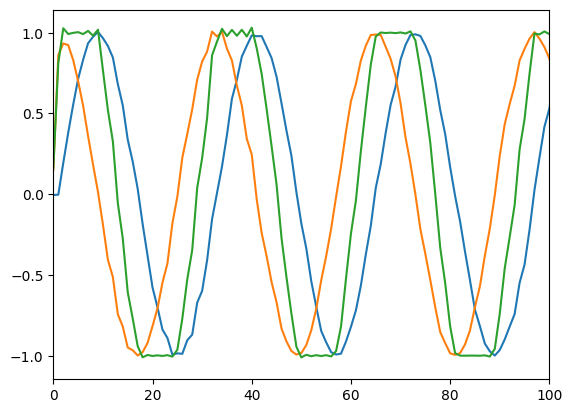

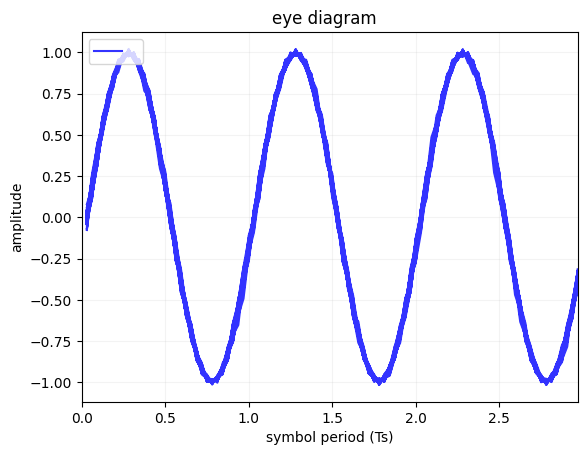

In [9]:
Fs = 3200
fc = 100

t = np.arange(0, 10000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.array([np.sin(2*π*fc*t), np.cos(2*π*fc*t), np.sin(2*π*fc*t)+np.cos(2*π*fc*t)]).T

# ADC input parameters
param = parameters()
param.Fs_in = Fs
param.Fs_out = Fs
param.jitter_rms = 5e-5
param.nBits =  16
param.Vmax = 1
param.Vmin = -1
param.AAF = True
param.N = 512

sig_adc = adc(sig, param)

plt.plot(sig_adc)
plt.xlim(0,100);

eyediagram(sig_adc[:,0], sig_adc.shape[0], int(param.Fs_out//fc), n=3, ptype='fast', plotlabel=None)

ΔFs = 56.25 ppm


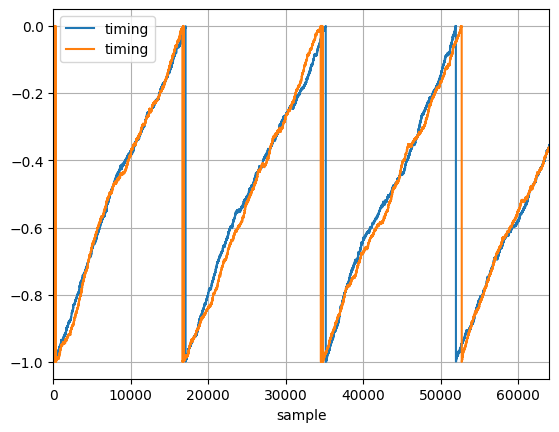

In [10]:
# simulation parameters
SpS = 16          # samples per symbol
M = 16            # order of the modulation format
Rs = 32e9         # Symbol rate (for OOK case Rs = Rb)
Fs = SpS*Rs       # Sampling frequency in samples/second
Ts = 1/Fs         # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(np.log2(M)*64e3))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization

symbTx = symbTx.reshape(-1,2)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rc', SpS, N=2001, alpha=0.01)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

downSample = 7.99955

ΔFs = (Fs/downSample-Fs/8)/(Fs/8)*1e6

print(f'ΔFs = {ΔFs:.2f} ppm')

sigRxRef = clockSamplingInterp(sigTx.reshape(-1,1), Fs, Fs/8, 0)

# ADC input parameters
paramADC = parameters()
paramADC.Fs_in = Fs
paramADC.Fs_out = Fs/downSample
paramADC.jitter_rms = 0.1e-12
paramADC.nBits =  10
paramADC.Vmax = 1.5
paramADC.Vmin = -1.5
paramADC.AAF = False
paramADC.N = 4001

sigRx = adc(sigTx, paramADC)

paramCLKREC = parameters()
paramCLKREC.isNyquist = True
paramCLKREC.returnTiming = True
paramCLKREC.ki = 1e-6
outCLK, ted_values = gardnerClockRecovery(sigRx, paramCLKREC)


plt.figure()
plt.plot(ted_values, label = 'timing')
plt.xlabel('sample')
plt.grid()
plt.xlim([0, len(sigRx)])
plt.legend()

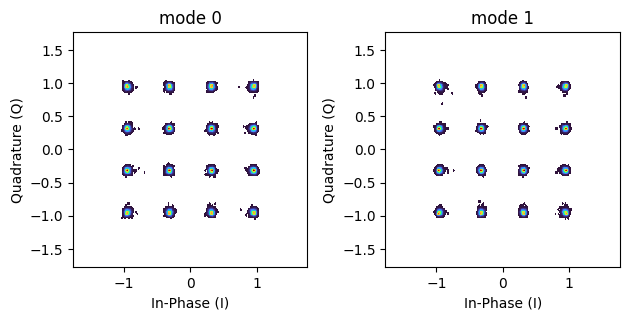

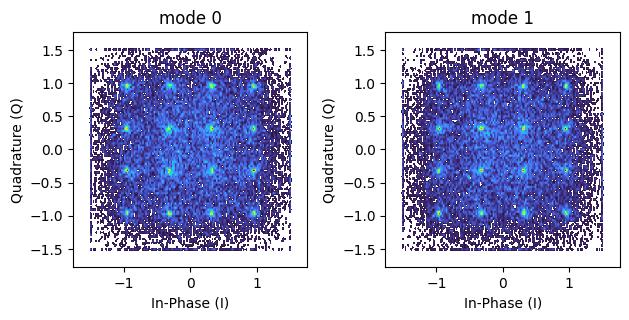

In [11]:
pconst(outCLK[10000:-2:2],pType='fancy');
pconst(sigRx[10000:-2:2], pType='fancy');

In [ ]:
#plt.plot(sigRx[10000:10050],'kx', label=f'SpS = {SpS/downSample}')
plt.plot(outCLK[20000:20200:2],'bo', label= 'Out clock recovery')
plt.plot(np.roll(sigRxRef,5)[20001:20200:2],'r.', label='SpS = 2')
plt.xlabel('sample')
plt.grid()
#plt.xlim([0, len(sigRx[0:50])])
plt.legend()

In [ ]:
finddelay(outCLK[::2], sigRxRef[::2].reshape(-1,))